# [Deep Learning for Vision Systems](https://www.manning.com/books/deep-learning-for-vision-systems?a_aid=compvisionbookcom&a_bid=90abff15) Book


## Chapter 6 Project: Sign language exercise

---
### 1. Import the libraries that we need

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
from pathlib import Path
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import load_files
from keras.utils import np_utils

%matplotlib inline

### 2. Data preparation

In [6]:
train_path  = 'data/train'
valid_path  = 'data/valid'
test_path  = 'data/test'
N=50

In [7]:
# ImageDataGenerator generates batches of tensor image data with real-time data augmentation. 
# The data will be looped over (in batches).
# in this example, we won't be doing any image augmentation
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(1280,960), 
                                                         batch_size=30
                                                         )

valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(1280,960), 
                                                         batch_size=30)

test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(1280,960), 
                                                        batch_size=30, 
                                                        shuffle=False)

Found 416 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 118 images belonging to 2 classes.


### 3. VGG16 base model pre-trained on ImageNet dataset

In [8]:
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (1280,960,3), pooling='avg')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1280, 960, 3)      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 1280, 960, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 1280, 960, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 640, 480, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 640, 480, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 640, 480, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 320, 240, 128)     0     

### 2. freeze the classification layers in the base model

In [9]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers[:-5]:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1280, 960, 3)      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 1280, 960, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 1280, 960, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 640, 480, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 640, 480, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 640, 480, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 320, 240, 128)     0     

In [10]:
# use “get_layer” method to save the last layer of the network
last_layer = base_model.get_layer('global_average_pooling2d_1')

# save the output of the last layer to be the input of the next layer
last_output = last_layer.output

# add our new softmax layer with 3 hidden units
x = Dense(2, activation='softmax', name='softmax')(last_output)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)

# print the new_model summary
new_model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1280, 960, 3)      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 1280, 960, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 1280, 960, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 640, 480, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 640, 480, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 640, 480, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 320, 240, 128)     0   

### 4. Train the new model

In [11]:
new_model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='schlieren.model.hdf5', save_best_only=True)

history = new_model.fit_generator(train_batches, steps_per_epoch=18,
                   validation_data=valid_batches, validation_steps=3, epochs=N, verbose=1, callbacks=[checkpointer])

Epoch 1/50


In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig("loss.png")

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig("accu.png")

### 5. Evaluation

In [1]:
def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets

In [2]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

test_files, test_targets = load_dataset('data/test')

Using TensorFlow backend.


In [3]:
from keras.preprocessing import image  
from keras.applications.vgg16 import preprocess_input
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(1280,960,3))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))

100%|██████████| 118/118 [00:02<00:00, 57.53it/s]


In [20]:
new_model = load_model('./1st/schlieren.model.hdf5')
# new_model = load_model('/home/hhuan006/Desktop/schlieren project/rio1/result/result_721/my_best_model.hdf5')
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets, batch_size=10)))

118/118 [==============================] - 14s 121ms/step

Testing loss: 0.9458
Testing accuracy: 0.7203


### 6. create the confusion matrix to evaluate the model

from keras.preprocessing import image  
from keras.applications.vgg16 import preprocess_input
from tqdm import tqdm
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

import cv2

import shutil
import matplotlib.pyplot as plt 


In [15]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(1280,960,3))
    # convert PIL.Image.Image type to 3D tensor with shape (1280,960, 1280,960, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 1280,960, 1280,960, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [16]:
test_dir = 'data/test'
tp=0
tn=0
fp=0
fn=0
t_path = Path(test_dir)
new_model = load_model('./1st/schlieren.model.hdf5')
classlist = [str(p.absolute()) for p in list(t_path.glob('*'))]
# print(os.path.basename(folderpath))


In [17]:
for i,clas in enumerate(classlist):
    testlist = os.listdir(clas)
#     print(testlist)
#     print(i)
    for ea in testlist:
        
        img_name = path_to_tensor(clas+'/'+ea)
        name_str = os.path.basename(str(ea))
    #     im = cv2.imread(img)
    #     x = image.img_to_array(im)
    #     x = np.expand_dims(im, axis=0)
        result_pre = new_model.predict(img_name)
    #     print(result_pre.size)
#         print(result_pre)
    #     if result_pre[0][1]>0.75:
        if result_pre[0][1]>result_pre[0][0] and i == 0:
            tp+=1
        if result_pre[0][1]<result_pre[0][0] and i == 0:
            fn+=1
        if result_pre[0][1]>result_pre[0][0] and i == 1:
            fp+=1
        if result_pre[0][1]<result_pre[0][0] and i == 1:
            tn+=1

In [18]:
cm = [[tp,   fn],
       [  fp,  tn]]
print(cm)

[[56, 3], [0, 59]]


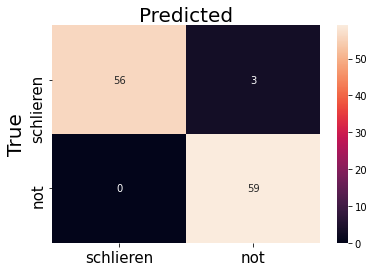

In [19]:
%matplotlib inline 
# above is necessary to visualize the graph in jupyter notebook
# Plot confusion matrix in a beautiful manner

fig = plt.figure()
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('top') 
ax.xaxis.set_ticklabels(['schlieren', 'not'], fontsize = 15)
# ax.xaxis.tick_top()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(['schlieren', 'not'], fontsize = 15)

plt.show()
fig.savefig('matrix.png')

### The End!